# Calar Alto NGC5395 and NGC5394 observation
Author: Máximo Rodríguez Herrero

maximo.rodriguez@estudiante.uam.es

Universidad Autónoma de Madrid

In [1]:
import os 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from astropy.io import fits
from photutils.aperture import CircularAperture, aperture_photometry

from IPython.display import Image

# plotting functions
from functions_maxi import my_plot, my_plot_log, sky_histogram
# reshaping and sky substraction functions
from functions_maxi import cut_master_frames, sky_squares_median, SkyInteractive
# flux calibration
from functions_maxi import CalibrationStars

C:\Users\Maxi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_path = os.path.join('.', 'TFG_EXP_2022')
fits_files = os.listdir(data_path)

In [3]:
# complete path of the fits files: directory + filename
fits_paths = list(map(lambda fits_file: os.path.join(data_path, fits_file), fits_files))

In [4]:
# open all the fits files and save their hdu into a list
hdu_2022 = np.array(list(map(lambda file: fits.open(file), fits_paths)))

In [5]:
def header_object(hdu):
    """returns the info: Object, Naxis1, Naxis2, Exposure Time"""
    return hdu[0].header['OBJECT'], hdu[0].header['NAXIS1'], hdu[0].header['NAXIS2'], hdu[0].header['EXPTIME']

def data_object(hdu):
    """returns the IMAGE DATA"""
    return hdu[0].data

def file_mask(hdu):
    """given the hdu of a fits file returns True only if it is one of the needed images"""
    if 'img' in hdu[0].header['OBJECT']:
        # True for the bias frames we need
        return True
    elif 'dome R 50W' in hdu[0].header['OBJECT']:
        return True
    elif 'dome B 50W' in hdu[0].header['OBJECT']:
        return True
    elif 'dome V 50W' in hdu[0].header['OBJECT']:
        return True
    elif 'skyflat Halpha' in hdu[0].header['OBJECT']:
        return True
    elif 'NGC' in hdu[0].header['OBJECT']:
        return True
    else:
        return False
# create the boolean mask of the images that will be use:
mask = list(map(file_mask, hdu_2022))
# final useful science images: 
hdu_science = hdu_2022[mask]
# scienec images in numpy format:
science_data = np.array(list(map(data_object, hdu_science)), dtype = object)
# quick view of the basic information: 
hdu_science_info = np.array(list(map(header_object, hdu_science)), dtype = str)

print('Info: Object, Naxis1, Naxis2, Exposure Time:\n')
print(hdu_science_info)

Info: Object, Naxis1, Naxis2, Exposure Time:

[['[bias] img' '1601' '1601' '0.0']
 ['[bias] img' '1601' '1601' '0.0']
 ['[bias] img' '1601' '1601' '0.0']
 ['[bias] img' '1601' '1601' '0.0']
 ['[bias] img' '1601' '1601' '0.0']
 ['[bias] img' '1601' '1601' '0.0']
 ['[bias] img' '1601' '1601' '0.0']
 ['[bias] img' '1601' '1601' '0.0']
 ['[bias] img' '1601' '1601' '0.0']
 ['[bias] img' '1601' '1601' '0.0']
 ['[flat] dome R 50W' '1601' '1601' '0.9']
 ['[flat] dome R 50W' '1601' '1601' '0.9']
 ['[flat] dome R 50W' '1601' '1601' '0.9']
 ['[flat] dome R 50W' '1601' '1601' '0.9']
 ['[flat] dome R 50W' '1601' '1601' '0.9']
 ['[flat] dome V 50W' '1601' '1601' '4.0']
 ['[flat] dome V 50W' '1601' '1601' '4.0']
 ['[flat] dome V 50W' '1601' '1601' '4.0']
 ['[flat] dome V 50W' '1601' '1601' '4.0']
 ['[flat] dome V 50W' '1601' '1601' '4.0']
 ['[flat] dome B 50W' '1601' '1601' '22.0']
 ['[flat] dome B 50W' '1601' '1601' '22.0']
 ['[flat] dome B 50W' '1601' '1601' '22.0']
 ['[flat] dome B 50W' '1601' '16

## Alingment to the CCD coordinates:
The entry "DATASEC" of the header gives the (0,0) of each image in the CCD coordinates but for the data reduction we need the images to be aligned in such a way that each pixel of each image (calibration of science) represents the same pixel of the CCD. Hence, we make the cut in the calibration image taking into account that the science image is displaced,

$$\delta_x^{cal} = x1_{sci}^{CCD} - x1_{cal}^{CCD}$$

$$\delta_y^{cal} = y1_{sci}^{CCD} - y1_{cal}^{CCD}$$

with respect to the calibration image origin, as shown in the image bellow.



In [6]:
Image(url = 'IMAGES/CCD_MAP.png', width = 350, height = 200)

### Index slicing: Creating the mask for each type of image

Boolean type vector.\
np.char.find returns the index of the first apereance of the str in the array so for bias and flat it will be 1 if any (because 0 is for '\[') and for NGC it will be 0 

In [7]:
mask_bias_frames = np.char.find(hdu_science_info[:,0], 'bias') == 1
mask_flats_frames = np.char.find(hdu_science_info[:,0], 'flat') == 1
mask_sci_frames = np.char.find(hdu_science_info[:,0], 'NGC') == 0

In [8]:
def header_datasec(hdu):
    """returns the info: Datasec 
    given the primary object of an HDU"""
    replaced = hdu[0].header['DATASEC'].replace('[', '').replace(']', '').replace(':', ',')
    x1, y1, x2, y2 = replaced.split(',')
    return int(x1), int(y1), int(x2), int(y2)

# display info:
print('CCD coor. (x1, y1, x2, y2)\n')

# bias dataset coordinates:
x1_bias, y1_bias, x2_bias, y2_bias = header_datasec(hdu_science[mask_bias_frames][0])
print('BIAS: ', x1_bias, y1_bias, x2_bias, y2_bias)

# flats dataset coordinates:
print('FLATS: ')
x1_dome, y1_dome, x2_dome, y2_dome =  header_datasec(hdu_science[mask_flats_frames][0])
print('\t-DOME: ', x1_dome, y1_dome, x2_dome, y2_dome)
x1_sky, y1_sky, x2_sky, y2_sky = header_datasec(hdu_science[mask_flats_frames][-1])
print('\t-SKY:  ', x1_sky, y1_sky, x2_sky, y2_sky)

# science dataset coordinates:
x1_sci, y1_sci, x2_sci, y2_sci = header_datasec(hdu_science[mask_sci_frames][0])
print('SCIENCE: ', x1_sci, y1_sci, x2_sci, y2_sci)

CCD coor. (x1, y1, x2, y2)

BIAS:  200 200 1800 1800
FLATS: 
	-DOME:  200 200 1800 1800
	-SKY:   513 513 1536 1536
SCIENCE:  513 513 1536 1536


## Master Bias

In [9]:
mask_bias_frames

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [10]:
# using the mask we select the data that correspond to the bias calibration images
bias_data = science_data[mask_bias_frames]
# change the arrays of arrays to a unique array such that we have 10 cal images (sum mask) and the appropiate dims
bias_data = np.concatenate(bias_data).reshape(sum(mask_bias_frames), 1601, 1601)

In [11]:
# median of the bias frames
master_bias = np.nanmedian(bias_data, axis = 0)

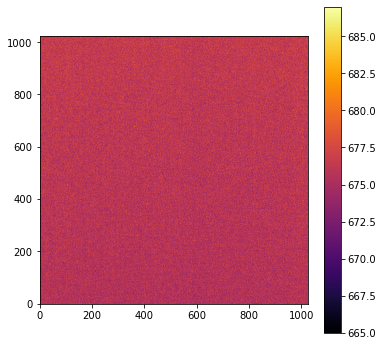

(1024, 1024)

In [12]:
master_bias_cut = cut_master_frames(master_bias, x1_sci - x1_bias, y1_sci - y1_bias, (1024, 1024))
my_plot(master_bias_cut)
master_bias_cut.shape

## Master Flats

In [13]:
mask_flats_frames

array([False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False])

In [14]:
# extra the flat header information: sky vs dome
flats_type = hdu_science_info[mask_flats_frames][:, 0]
# flats calibration images
flats_cal = science_data[mask_flats_frames]

In [15]:
flats_data = {}
for key, data in zip(flats_type, flats_cal):
    # separate dome flats of sky flats
    if 'dome' in key: x1_flats = x1_dome; y1_flats = y1_dome; 
    else: x1_flats = x1_sky; y1_flats = y1_sky;
    
    if key not in flats_data:
        flats_data[key] = []
        raw_flats = data - cut_master_frames(master_bias, x1_sci - x1_flats, y1_sci - y1_flats, np.array(data).shape) 
        raw_flats /= np.nanmedian(raw_flats)
        flats_data[key].append(raw_flats)
    else:
        raw_flats = data - cut_master_frames(master_bias, x1_sci - x1_flats, y1_sci - y1_flats, np.array(data).shape)
        raw_flats /= np.nanmedian(raw_flats)
        flats_data[key].append(raw_flats)
flats_data.keys()

dict_keys(['[flat] dome R 50W', '[flat] dome V 50W', '[flat] dome B 50W', '[flat] skyflat Halpha'])

### Median of every exposure and resize the frames if necessary

In [16]:
master_flats = {}
for key, data in flats_data.items():
    if 'dome' in key: x1_flats = x1_dome; y1_flats = y1_dome; 
    else: x1_flats = x1_sky; y1_flats = y1_sky;
    master_flats[key] = cut_master_frames(np.nanmedian(np.array(data), axis = 0), 
                                          x1_sci - x1_flats, y1_sci - y1_flats, 
                                          (1024, 1024))

[flat] dome R 50W


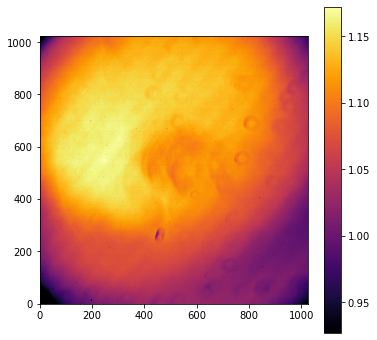

[flat] dome V 50W


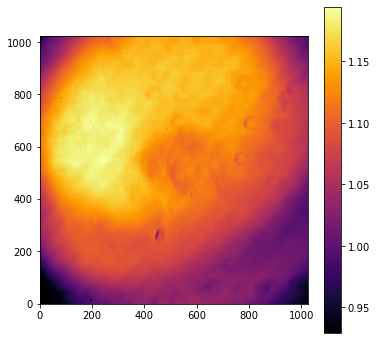

[flat] dome B 50W


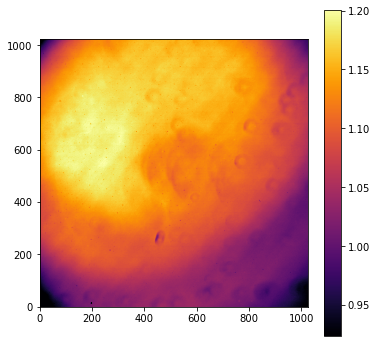

[flat] skyflat Halpha


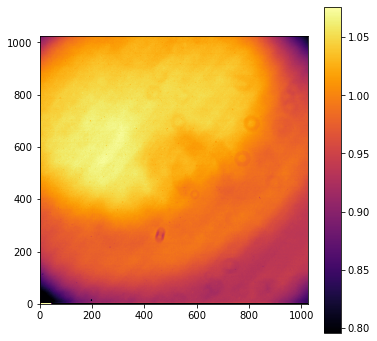

In [17]:
%matplotlib inline
for key, value in master_flats.items():
    print(key)
    my_plot(value)
    value.shape

## Science image reduction

In [18]:
mask_sci_frames

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [19]:
# find the name of the filters used in the observation to name the entry of the dictionary 
list(np.unique(hdu_science_info[mask_sci_frames][:, 0]))

['NGC 5395 B', 'NGC 5395 Halpha', 'NGC 5395 R', 'NGC 5395 V']

In [20]:
# same dict with different keys
master_flats = dict([(key, value) for key, value in zip(['NGC 5395 R', 
                                                         'NGC 5395 V', 
                                                         'NGC 5395 B',
                                                         'NGC 5395 Halpha'], 
                                                          master_flats.values())])

In [21]:
def clean_saturated_pixels(image, N_sat = 55000):#2e16 - 1):
    image = image.astype(float)
    sat_pixels = (image >= N_sat)
    image[sat_pixels] = np.nan
    return image
def set_zero_to_nan(image):
    image = image.astype(float)
    zero_pixels = (image <= 0)
    image[zero_pixels] = np.nan
    return image

In [22]:
sci_data = {}
i = 0
for key, data in zip(hdu_science_info[mask_sci_frames][:, 0], science_data[mask_sci_frames]):
    EXPTIME = float(hdu_science_info[mask_sci_frames][:, 3][i])
    data = clean_saturated_pixels(data)
    if key not in sci_data:
        sci_data[key] = []
        raw_sci = (data - master_bias_cut)/(set_zero_to_nan(master_flats[key]*EXPTIME))
        sci_data[key].append(raw_sci)
    else:
        raw_sci = (data - master_bias_cut)/(set_zero_to_nan(master_flats[key]*EXPTIME))
        sci_data[key].append(raw_sci)
    i += 1
sci_data.keys()

dict_keys(['NGC 5395 R', 'NGC 5395 B', 'NGC 5395 V', 'NGC 5395 Halpha'])

NGC 5395 R


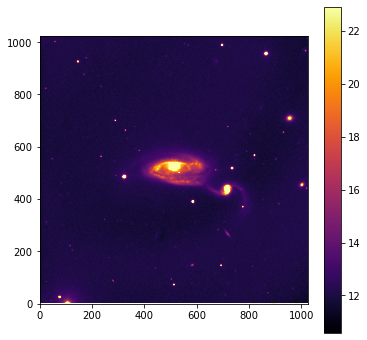

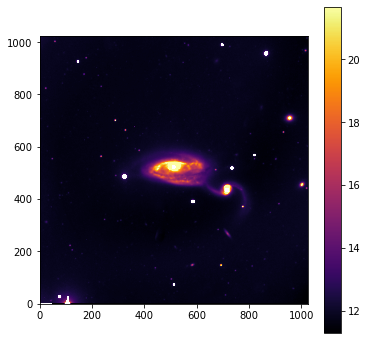

NGC 5395 B


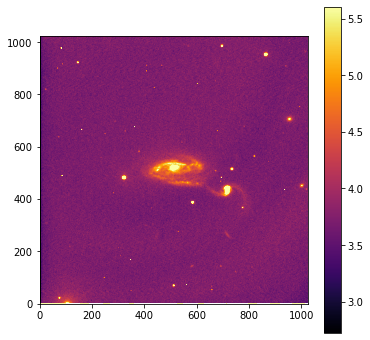

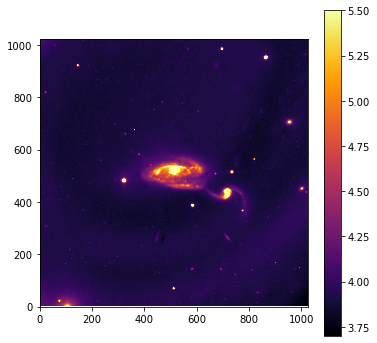

NGC 5395 V


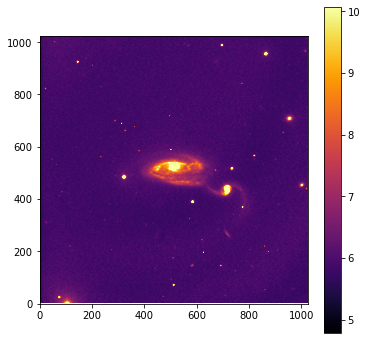

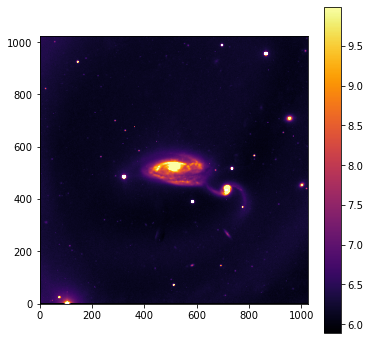

NGC 5395 Halpha


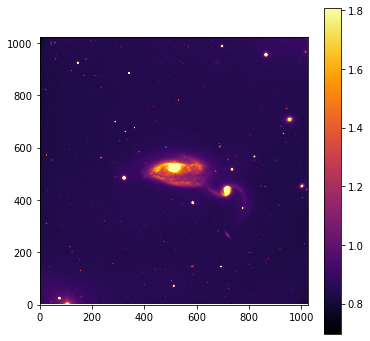

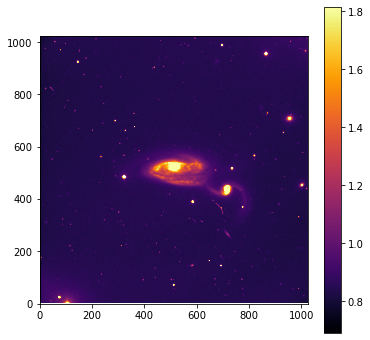

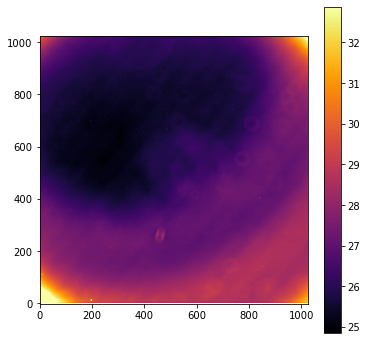

In [23]:
for key, value in sci_data.items():
    print(key)
    for i in value:
        my_plot(np.array(i))
   # my_plot(np.array(value)[1])
   # np.array(value).shape

In [24]:
# removing the damaged image of the H_Alpha filter
remove = sci_data['NGC 5395 Halpha'].pop()

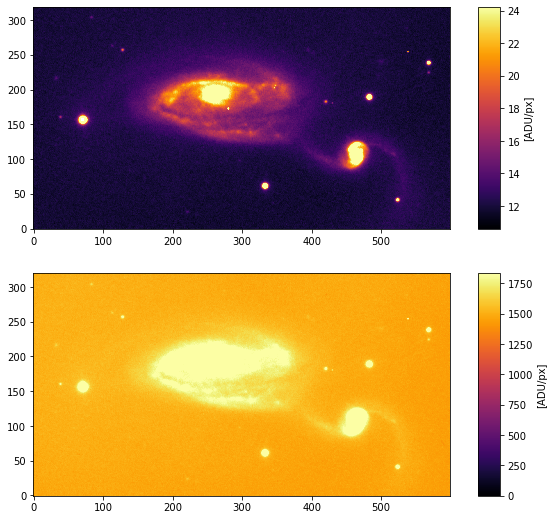

In [25]:
# comparisson pre and post noise reduction
%matplotlib inline
name = 'NGC 5395 R'
image1 = sci_data[name][0]
image2 = science_data[mask_sci_frames][0]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 9))#, constrained_layout=True)
  
show1 = ax1.imshow(image1[330:650, 250:850], origin='lower',
                     vmin=np.nanpercentile(image1, 0.25),
                     vmax=np.nanpercentile(image1, 99.8),
                     cmap='inferno')
show2 = ax2.imshow(image2[330:650, 250:850], origin='lower',
                     vmin=np.nanpercentile(image2, 0),
                     vmax=np.nanpercentile(image2, 99),
                     cmap='inferno')

plt.colorbar(show1, ax=ax1, aspect=10, label='[ADU/px]', pad=0.05)
plt.colorbar(show2, ax=ax2, aspect=10, label='[ADU/px]', pad=0.05)
plt.show()
# fig.savefig('IMAGES/noise_reduction.png')

### Sky substraction
In order to compute the sky background counts coming from the sky I am using the class SkyInteractive so an interactive plot (whit higher contrast than normal) is display and using the sliders (x1, x2, y1, y2) we cut the image into 8 rectangles can be created, feeding those values to the function sky_squares_median the mode of every rectangle is computed and then the median of those modes is returned.

Here I'm using the default values (200, 900, 200, 750) as they work fine for every image and every filter but if needed feel free to play with it, take into account that the x and y coordinates are the typical physical coordinates, meaning: x -> row and y -> column. It is also more precise to directly right the number in the box instead of using the slider.
Example image:

In [78]:
Image(url = 'IMAGES/sky_sub.png')

interactive(children=(IntSlider(value=200, description='x1', max=1023), IntSlider(value=900, description='x2',…

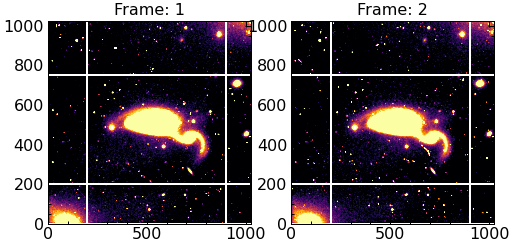

In [73]:
%matplotlib widget
halpha = SkyInteractive(sci_data['NGC 5395 Halpha'])
#.values() = (200, 900, 200, 750)

In [27]:
# %matplotlib widget
# ngcR = SkyInteractive(sci_data['NGC 5395 R'], (200, 900, 200, 750))

In [28]:
# %matplotlib widget
# ngcB = SkyInteractive(sci_data['NGC 5395 B'], (200, 900, 200, 750))

In [29]:
# %matplotlib widget
# ngcR = SkyInteractive(sci_data['NGC 5395 V'], (200, 900, 200, 750))

In [30]:
x1, x2, y1, y2 = halpha.get_cuts()

Checking the sky substraction

Sky substraction: NGC 5395 R


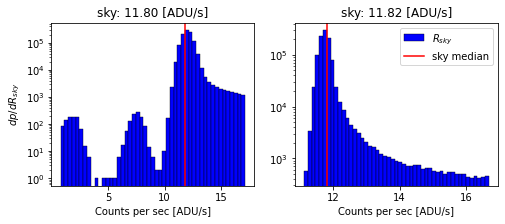

Sky substraction: NGC 5395 B


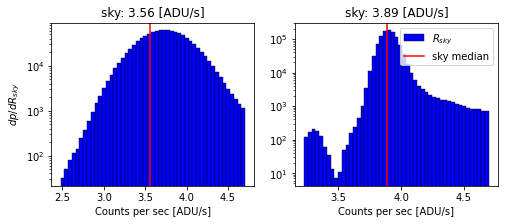

Sky substraction: NGC 5395 V


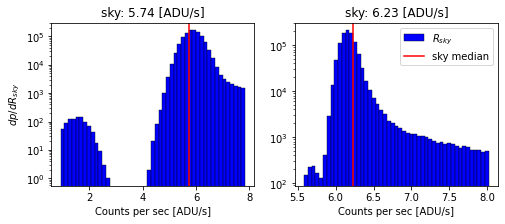

Sky substraction: NGC 5395 HALPHA


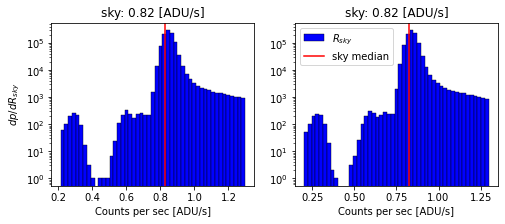

In [31]:
%matplotlib inline
sky_histogram(sci_data, x1, x2, y1, y2)

### Final reduction

In [32]:
def reduce_stack(x1, x2, y1, y2, data, exp_time):
    """substraction of the sky and simple stacking of the exposures. 
    The stacking is simply the ponderated (with respect the exposure times)
    sum of every image.
    - input:
        - x1, x2, y1, y2: row and column numbers for horizontal/vertical cuts
        - data: image
        - exp_time: exposure time of every science image"""
    sky0 = sky_squares_median(x1, x2, y1, y2, data[0])
    sky1 = sky_squares_median(x1, x2, y1, y2, data[1])

    reduced_image0 = data[0] - sky0
    reduced_image1 = data[1] - sky1

    reduced_image0[reduced_image0 <= 0] = 0 + sky0/50 # prevent infinite values in log plots
    reduced_image1[reduced_image1 <= 0] = 0 + sky1/50 # prevent infinite values in log plots

    reduced_image0[np.isinf(reduced_image0)] = np.nan # mark inf pixels as nan 
    reduced_image1[np.isinf(reduced_image1)] = np.nan # mark inf pixels as nan        
    
    reduced = (exp_time[0] * reduced_image0 + exp_time[1] * reduced_image1) / np.sum(exp_time)
    my_plot(reduced)
    #my_plot_log(reduced)
    return reduced

#### H ALPHA

In [33]:
exp_time = hdu_science_info[hdu_science_info[:, 0] == 'NGC 5395 Halpha'][:, 3][:-1].astype('float64')
print('EXP TIMES: ', exp_time)

EXP TIMES:  [1200. 1200.]


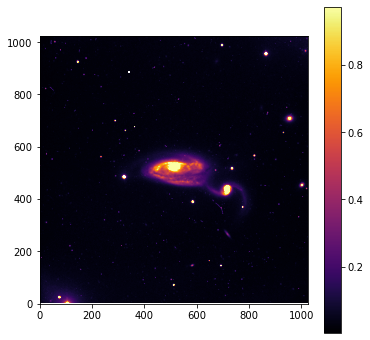

In [34]:
%matplotlib inline
reduce_halpha = reduce_stack(x1, x2, y1, y2, sci_data['NGC 5395 Halpha'], exp_time)

#### NGC 5395 R

In [35]:
exp_time = hdu_science_info[hdu_science_info[:, 0] == 'NGC 5395 R'][:, 3].astype('float64')
print('EXP TIMES: ', exp_time)

EXP TIMES:  [ 60. 900.]


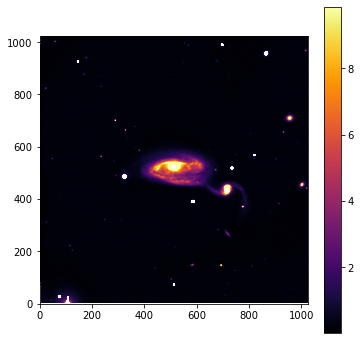

In [36]:
%matplotlib inline
reduce_ngcR = reduce_stack(x1, x2, y1, y2, sci_data['NGC 5395 R'], exp_time)

#### NGC 5395 V

In [37]:
exp_time = hdu_science_info[hdu_science_info[:, 0] == 'NGC 5395 V'][:, 3].astype('float64')
print('EXP TIMES: ', exp_time)

EXP TIMES:  [ 60. 900.]


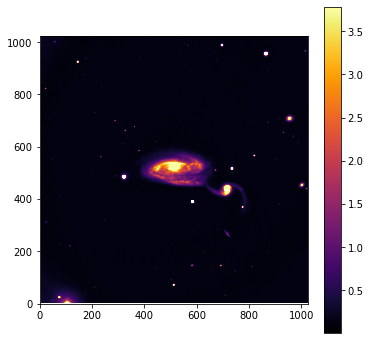

In [38]:
%matplotlib inline
reduce_ngcV = reduce_stack(x1, x2, y1, y2, sci_data['NGC 5395 V'], exp_time)

#### NGC 5395 B

In [39]:
exp_time = hdu_science_info[hdu_science_info[:, 0] == 'NGC 5395 B'][:, 3].astype('float64')
print('EXP TIMES: ', exp_time)

EXP TIMES:  [ 60. 900.]


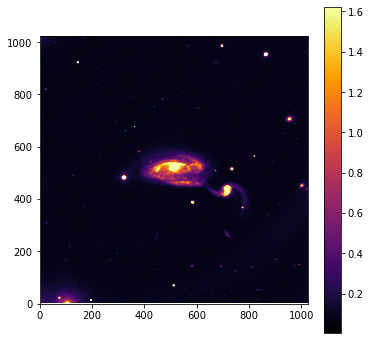

In [40]:
%matplotlib inline
reduce_ngcB = reduce_stack(x1, x2, y1, y2, sci_data['NGC 5395 B'], exp_time)

In [41]:
stacked_dict = {key: value for key, value in zip(['NGC 5395 R', 'NGC 5395 B', 'NGC 5395 V'], 
                                                 [reduce_ngcR, reduce_ngcB, reduce_ngcV])}

## Calibracion en flujo

https://photutils.readthedocs.io/en/stable/aperture.html

### Calibration stars selection

In [42]:
Image(url = 'IMAGES/estrellas_calibracion.png', width = 500, height = 200)

#### CalibrationStars Use Guide
Click one time on the left plot to select calibration star, this star will appear
on the right plot, click one more time (now more accurately in the center of the star and 
one last time on its radius. Now that the centre location and the radius of this calibration 
star is saved click again on the new calibration on the left plot.\
Repeat the process until every star with its respective radius is selected.
Example image:

In [81]:
Image(url = 'IMAGES/cal_star.png')

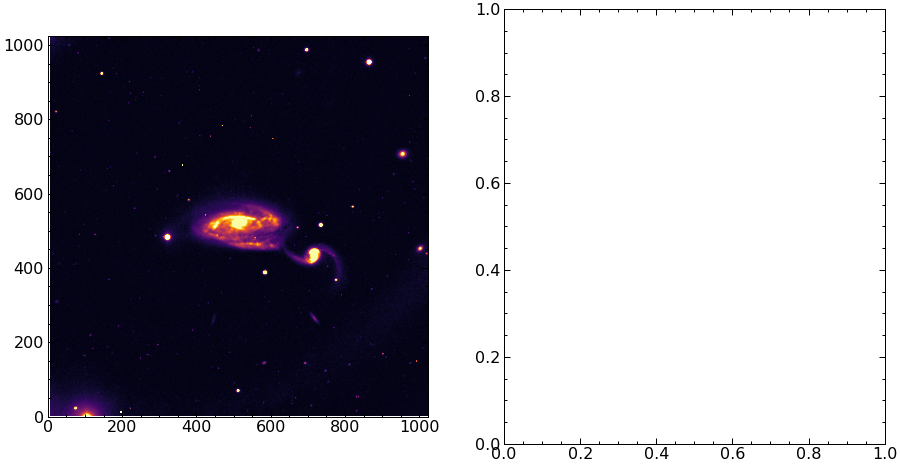

In [79]:
from ipywidgets import interactive
%matplotlib widget
# one click on the left image to select the star, 
# two clicks on the rigth image to select, first, the center and then 
# the radius
stars = CalibrationStars(reduce_ngcB)

In [84]:
# Comment this cell if you use the interactive selector, 
# here the default values of previous selections:
# calib_stars {((i, j), aperture)}
# default values if you dont use the interactive function
stars.calib_stars = {1: (np.array([986, 694]), 5),
                     2: (np.array([565, 818]), 5),
                     3: (np.array([388, 582]), 6),
                     4: (np.array([ 70, 510]), 5)}

Sky server to find the tabulated ugriz magnitudes,

https://skyserver.sdss.org/dr18/

In [82]:
# u, g, r, i values of each calib star 
# star 1: SDSS ID: 1237662225149722764 
# star 2: SDSS ID: 1237662225149722679
# star 3: SDSS ID: 1237662225149722675
# star 4: SDSS ID: 1237662225149722629
stars_sdss = {1: [17.61, 16.30, 15.78, 15.60], 
              2: [20.52, 17.98, 16.81, 16.33], 
              3: [16.69, 15.38, 14.93, 14.78],
              4: [17.95, 17.02, 16.77, 16.68]}

In [46]:
positions = [value[0] for value in stars.calib_stars.values()]
R = np.array([value[1] for value in stars.calib_stars.values()]).max() + 3 # max radius plus margin
R
# {1: ((45, 50), 8), 2: ((49, 49), 9), 3: ((47, 51), 8), 4: ((52, 49), 8)}

9

In [47]:
aperture = CircularAperture(positions, r = R)
# astropy photometry, position and total counts for an aperture R
phot_table = {filter_name: aperture_photometry(data, aperture) for filter_name, data in stacked_dict.items()}

# total counts for each star in every filter:
aperture_sum = {filter_name: np.array(aperture['aperture_sum']) for filter_name, aperture in phot_table.items()}
print(phot_table)
print(aperture_sum)

{'NGC 5395 R': <QTable length=4>
  id  xcenter ycenter    aperture_sum  
        pix     pix                    
int32 float64 float64      float64     
----- ------- ------- -----------------
    1   986.0   694.0 49.50312627209205
    2   565.0   818.0 52.70136001995543
    3   388.0   582.0 73.18908514992435
    4    70.0   510.0 59.83265563218724, 'NGC 5395 B': <QTable length=4>
  id  xcenter ycenter    aperture_sum   
        pix     pix                     
int32 float64 float64      float64      
----- ------- ------- ------------------
    1   986.0   694.0 18.172016960104642
    2   565.0   818.0 17.439381125131344
    3   388.0   582.0  31.92608986864152
    4    70.0   510.0  18.15197132110559, 'NGC 5395 V': <QTable length=4>
  id  xcenter ycenter    aperture_sum   
        pix     pix                     
int32 float64 float64      float64      
----- ------- ------- ------------------
    1   986.0   694.0  28.08036024809867
    2   565.0   818.0 30.337131075225187
    3  

Transformation from Johnson filters to SDSS 

http://classic.sdss.org/dr5/algorithms/sdssUBVRITransform.html#Lupton2005 

In [48]:
sdss_to_johnson = {'NGC 5395 B': lambda u, g, r, i: 0.5*(u - 0.8116*(u - g) + 0.1313) + 0.5*(g + 0.3130*(g - r) + 0.2271), 
                   'NGC 5395 V': lambda u, g, r, i: 0.5*(g - 0.2906*(u - g) + 0.0885) + 0.5*(g - 0.5784*(g - r) - 0.0038), 
                   'NGC 5395 R': lambda u, g, r, i: 0.5*(r - 0.1837*(g - r) - 0.0971) + 0.5*(r - 0.2936*(r - i) - 0.1439)}

In [49]:
# transform the sdss values (online survay) to jonhson
stars_johnson = {
    filter_name: np.array([sdss_to_johnson[filter_name](*stars_sdss[star]) for star in stars_sdss.keys()]) 
    for filter_name in stacked_dict.keys()}
stars_johnson

{'NGC 5395 R': array([15.585314 , 16.5115715, 14.7461475, 16.6133255]),
 'NGC 5395 B': array([16.683982, 18.581573, 15.753027, 17.325931]),
 'NGC 5395 V': array([16.001623, 17.314924, 15.101867, 16.854921])}

In [50]:
# magnitude of the total counts of the calibration stars
stars_mag = {filter_name: -2.5*np.log10(aperture) for filter_name, aperture in aperture_sum.items()}
stars_mag

{'NGC 5395 R': array([-4.23658157, -4.30455456, -4.6611158 , -4.4423457 ]),
 'NGC 5395 B': array([-3.14850783, -3.10382767, -3.76036433, -3.14730949]),
 'NGC 5395 V': array([-3.62100669, -3.70493627, -3.78070689, -3.74459388])}

In [51]:
# difference between the magnitude got from the total counts and the magnitude tabulated in online survays
stars_extinction = {filter_name: np.median(stars_mag[filter_name]
                                           -stars_johnson[filter_name]) for filter_name in stacked_dict.keys()}
stars_extinction

{'NGC 5395 R': -20.319010812051438,
 'NGC 5395 B': -20.15286516274376,
 'NGC 5395 V': -20.111072285252618}

In [52]:
# the science images in magnitudes: counts_mag - extinction
science_mag = {filter_name: -2.5*np.log10(stacked_dict[filter_name])
               -stars_extinction[filter_name] for filter_name in stacked_dict.keys()}

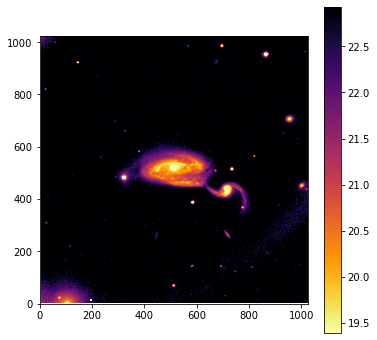

In [53]:
%matplotlib inline
my_plot(science_mag['NGC 5395 B'], cmap = 'inferno_r', percentiles = (.15, 60))

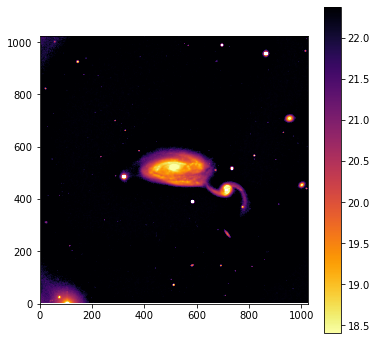

In [54]:
my_plot(science_mag['NGC 5395 V'], cmap = 'inferno_r', percentiles = (.15, 60))

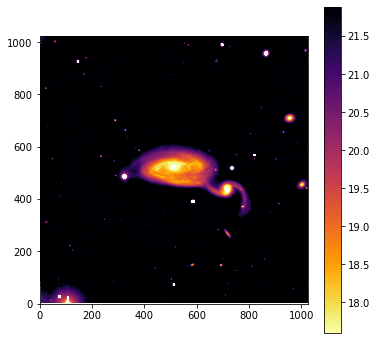

In [55]:
my_plot(science_mag['NGC 5395 R'], cmap = 'inferno_r', percentiles = (.15, 60))

#### Unit conversion: $mag/arcsec^2$

The pixel of CAFOS has an aperture equivalent to

$scale = 0.53 \cdot \frac{arcsec}{px}$

The images shown before are in the form, 

$image[mag/px^2] = -2.5 \log(image[counts/s/px^2])$

Therefore, the corresponding image can be easily computed as,  

$image[mag/arcsec^2] = -2.5 \log(\frac{image[counts/s/px^2]}{scale^2}) = image[mag/px^2]  + 2.5 \cdot \log([scale^2])$

In [56]:
pix_scale = .53 # arcsec/px
science_mag_arcsec = {filter_name: science_mag[filter_name] + 5*np.log10(pix_scale) for filter_name in science_mag.keys()}

# once mag/arsec2 is computed the ergs/s is trivial
# flux constant erg/s·cm^2
flux_0 = {'NGC 5395 B': 6.13e-9*776.44,'NGC 5395 V': 3.81e-9*908.50, 'NGC 5395 R': 2.15e-9*1546.91}
science_erg_arcsec = {key: flux_0[key]*np.power(10, -.4*value) for key, value in science_mag_arcsec.items()}

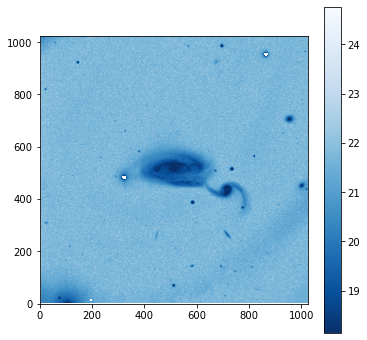

In [57]:
%matplotlib inline
my_plot(science_mag_arcsec['NGC 5395 B'], cmap = 'Blues_r', percentiles = (0.2, 99.9))

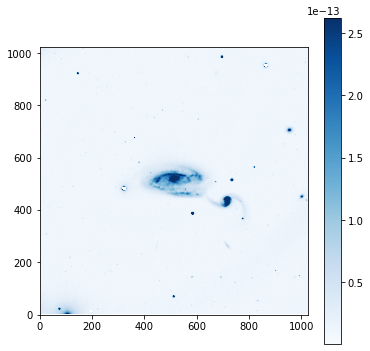

In [58]:
my_plot(science_erg_arcsec['NGC 5395 B'], cmap = 'Blues', percentiles = (0.3, 99.8))

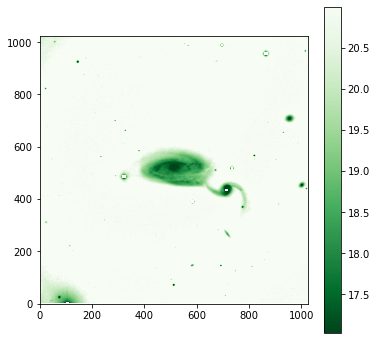

In [59]:
my_plot(science_mag_arcsec['NGC 5395 V'], cmap = 'Greens_r', percentiles = (0.15,60))

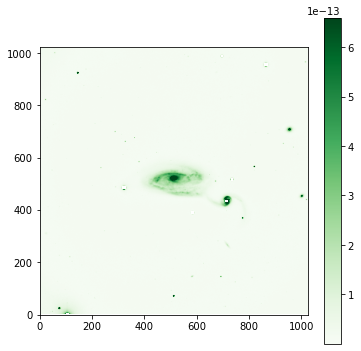

In [60]:
my_plot(science_erg_arcsec['NGC 5395 V'], cmap = 'Greens', percentiles = (0.01, 99.9))

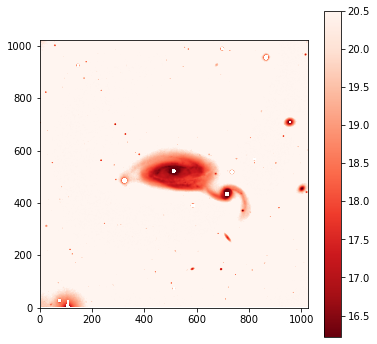

In [61]:
my_plot(science_mag_arcsec['NGC 5395 R'], cmap = 'Reds_r', percentiles = (0.15, 60))

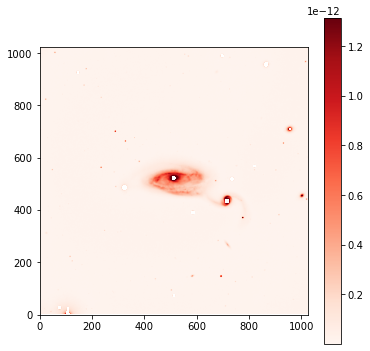

In [62]:
my_plot(science_erg_arcsec['NGC 5395 R'], cmap = 'Reds', percentiles = (0.01, 99.9))

## Stelar composition analysis

* **Population I**, or metal-rich, stars are young stars with the highest metallicity out of all three populations and are more commonly found in the spiral arms.

* **Population II**, or metal-poor, stars are those with relatively little of the elements heavier than helium.

In [63]:
B_V = science_mag['NGC 5395 B'] - science_mag['NGC 5395 V']
R = science_mag['NGC 5395 R']
mask_noise = (R>21)
mask_young = (R<21)&(B_V<0.85)
mask_old = (R<21)&(B_V>0.85)

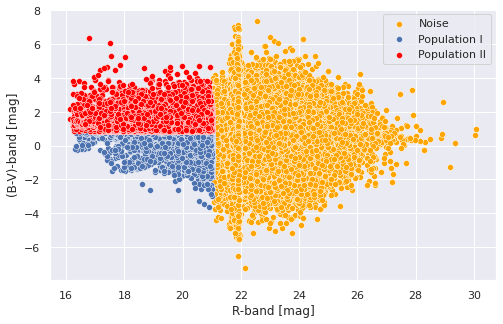

In [64]:
sns.color_palette('bright')
sns.set(rc={'figure.figsize':(8, 5)})
ax1 = sns.scatterplot(x = R[mask_noise].flatten(), y = B_V[mask_noise].flatten(), label='Noise', color='orange')
ax2 = sns.scatterplot(x = R[mask_young].flatten(), y = B_V[mask_young].flatten(), label='Population I', color='b')
ax3 = sns.scatterplot(x = R[mask_old].flatten(), y = B_V[mask_old].flatten(), label='Population II', color='red')
ax3.set(xlabel='R-band [mag]', ylabel='(B-V)-band [mag]')
plt.style.use('default')
# plt.savefig('IMAGES/color_index.png')
plt.show()

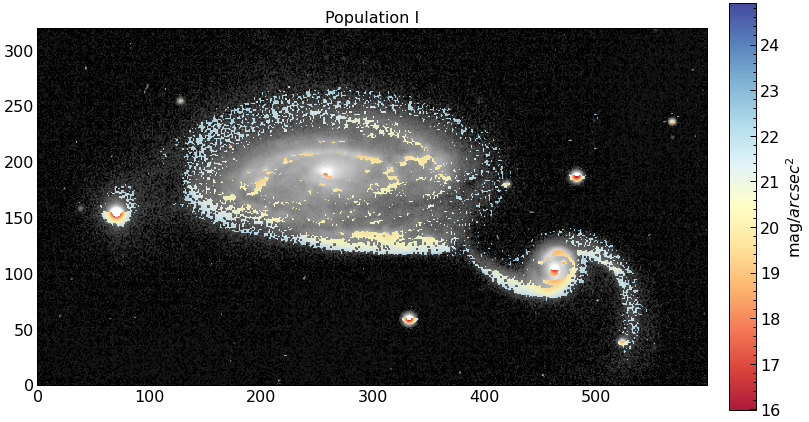

In [65]:
%matplotlib inline
plt.rcParams['axes.grid'] = False
plt.style.use(['science', 'notebook'])

img = science_mag['NGC 5395 B'].copy() 
img_young = science_mag['NGC 5395 B'].copy()

img_young[~mask_young] = np.nan

# zoom = np.zeros(img.shape, dtype = bool)
# zoom[270:820, 335:670] = True

fig, ax = plt.subplots(figsize = (15, 15))
    
ax.imshow(img[330:650, 250:850], origin = 'lower', 
          vmin = np.nanpercentile(img[330:650, 250:850], 0.1),
          vmax = np.nanpercentile(img[330:650, 250:850], 80),
          cmap = 'gray_r', 
          alpha = 1)
show = ax.imshow(img_young[330:650, 250:850], origin = 'lower', 
                 cmap = 'RdYlBu', 
                 alpha = 0.9)
plt.title('Population I')
plt.colorbar(show, shrink=0.5, aspect=15, anchor=(-0.2, 0.5), label='mag/$arcsec^2$')
plt.show() 
# fig.savefig('IMAGES/populationI.png')

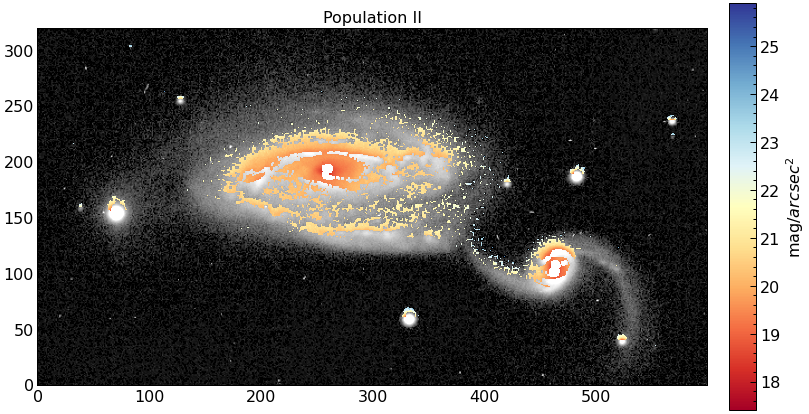

In [66]:
%matplotlib inline
plt.rcParams['axes.grid'] = False
plt.style.use(['science', 'notebook'])


img_old = science_mag['NGC 5395 B'].copy()

img_old[~mask_old] = np.nan

fig, ax = plt.subplots(figsize = (15, 15))
        
ax.imshow(img[330:650, 250:850], origin = 'lower', 
          vmin = np.nanpercentile(img[330:650, 250:850], 0.5),
          vmax = np.nanpercentile(img[330:650, 250:850], 80),
          cmap = 'gray_r', 
          alpha = 1)
show = ax.imshow(img_old[330:650, 250:850], origin = 'lower', 
                 cmap = 'RdYlBu', 
                 alpha = 1)
       
plt.colorbar(show, shrink=0.5, aspect=15, anchor=(-0.2, 0.5), label='mag/$arcsec^2$')
plt.title('Population II')
plt.show() 
# fig.savefig('IMAGES/populationII.png')

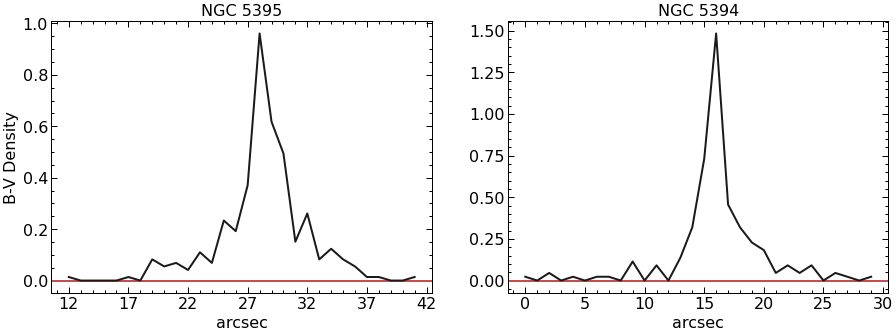

In [67]:
%matplotlib inline
plt.style.use(['science', 'notebook'])
B_V_arcsec_5395 = (science_mag_arcsec['NGC 5395 B'] - science_mag_arcsec['NGC 5395 V'])[192, 120:420]
B_V_arcsec_5394 = (science_mag_arcsec['NGC 5395 B'] - science_mag_arcsec['NGC 5395 V'])[105, 350:550]


hist_5395, bin_edges = np.histogram(B_V_arcsec_5395, bins=30, density=True)
hist_5394, bin_edges = np.histogram(B_V_arcsec_5394, bins=30, density=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.axhline(0, color='r')
ax1.plot(hist_5395, 'k-')
ax1.set_xticks(np.arange(0, 30+5, 5), np.arange(12, 42+5, 5))
ax1.set_xlabel('arcsec')
ax1.set_ylabel('B-V Density')
ax1.set_title('NGC 5395')

ax2.axhline(0, color='r')
ax2.plot(hist_5394, 'k-')
ax2.set_xlabel('arcsec')
ax2.set_title('NGC 5394')

plt.show()

## Color Image
The idea is to put the images of the R, B and V bands together such that we form an image of shape
(3, 1024, 1024) where the 3 represents the three primary colors.\
* Method 1: Every image consists of a matrix with values ranging from approximately zero to some number, 
first we rescale it such that the image is now ranging from zero to one. After that, we multiply by 255 and transform
the data type to integer allowing plt.imshow to treat it as RGB colors (0-255).
* Method 2: This second method is really similar to the first one, but this time we take into account that we cannot 
rescale the images individually so we rescale them to values ranging from 0 to the MAX VALUE OF ALL THE THREE IMAGES, 
therefore we are having into account that if one of the images has higher values it should be dominant in the final image, 
this second method is the one used in the scientific report since, although the first provides an interesting image, is the 
more correct of the two

In [68]:
def RGB_scale(image, alpha=10):
    """Function that changes the count scale to values between zero and one 
    and then, multiplying by 255, to color scale RGB
    - input: 
        - image: image to be rescaled
        - alpha: intensity factor"""
    image_RGB = (image - np.nanmin(image))/(np.nanmax(image)- np.nanmin(image))
    return 255 * image_RGB * alpha

In [69]:
science = np.array([RGB_scale(science_erg_arcsec['NGC 5395 R']), 
                    RGB_scale(science_erg_arcsec['NGC 5395 V']),
                    RGB_scale(science_erg_arcsec['NGC 5395 R'])], dtype=int)
science[np.isnan(science)] = 0
science[science < 0] = 0 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


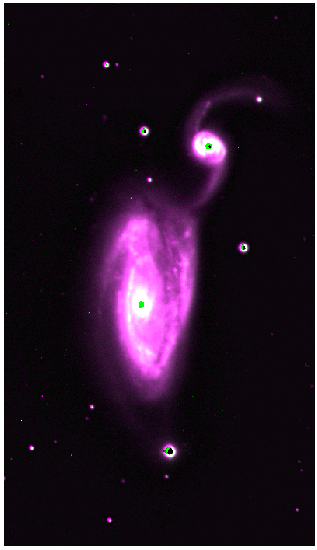

In [70]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
image = science.T[200:900, 300:700]

ax.imshow(image[::-1, ::-1, :], 
          interpolation='nearest')
          # vmin=np.nanpercentile(image, 0), 
          # vmax=np.nanpercentile(image, 100))
plt.axis('off')
plt.show()
# fig.savefig('IMAGES/NGC_RGB.png')

C:\Users\Maxi\AppData\Local\Temp\ipykernel_6400\2737066232.py:29: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(image[::-1, ::-1, :]),
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


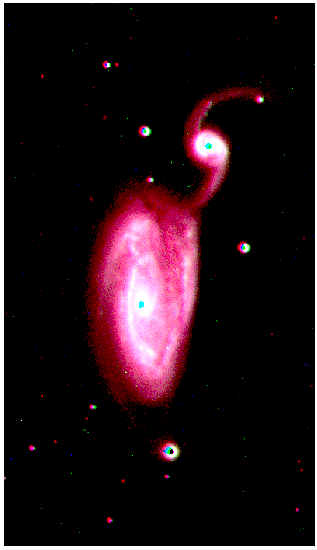

In [86]:
def RGB_scale(image_dict, alpha=1):
    """Function that changes the count scale to values between zero and one 
    and then, multiplying by 255, to color scale RGB
    THIS SECOND METHOD HAS INTO ACCOUNT THAT THE SCALE NEEDS TO BE THE SAME 
    FOR EVERY FILTER, THAT IS SAME MAX AND MIN COUNTS BEFORE RESCALING SO 
    THE RELATIVE STRENGTH OF EACH COLOR WITH RESPECT EACH OTHER IS KEPT
    - input: image
    - alpha: intensity factor, multiply every image by alpha so the """
    final_max = 0
    final_min = 1e3
    for key, value in image_dict.items():
        max_value = np.nanmax(value)
        min_value = np.nanmin(value)
        if max_value > final_max:
            final_max = max_value
        if min_value < final_min:
            final_min = min_value
  
    science_RGB = np.array([alpha*255*(value - final_min)/(final_max - final_min) for value in image_dict.values()], 
                           dtype=int)
    return science_RGB
science = RGB_scale(science_erg_arcsec)
science[np.isnan(science)] = 0
science[science < 0] = 0 

fig, ax = plt.subplots(figsize=(10, 10))
image = science.T[200:900, 300:700]

ax.imshow(image[::-1, ::-1, :], 
          interpolation='nearest')
plt.axis('off')
plt.show()
# fig.savefig('IMAGES/NGC_RGB_1.png')

## Structural Comparisson

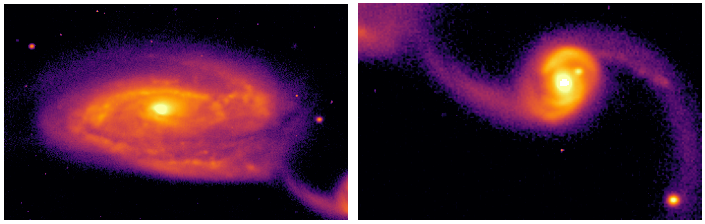

In [72]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
NGC9535 = science_mag_arcsec['NGC 5395 V'][410:630, 350:700]
NGC9534 = science_mag_arcsec['NGC 5395 V'][360:480, 600:790]
percentiles = (0.1, 60)
show1 = ax1.imshow(NGC9535, origin='lower',
                     vmin=np.nanpercentile(NGC9535, percentiles[0]),
                     vmax=np.nanpercentile(NGC9535, percentiles[1]),
                     cmap='inferno_r')
ax1.axis('off')
show2 = ax2.imshow(NGC9534, origin='lower',
                     vmin=np.nanpercentile(NGC9535, percentiles[0]),
                     vmax=np.nanpercentile(NGC9535, percentiles[1]),
                     cmap='inferno_r')
ax2.axis('off')
plt.tight_layout()
# plt.colorbar(show2, aspect=10, shrink=0.4, label='mag/$arcsec^2$')
plt.show()
fig.savefig('IMAGES/estructure.png')